In [28]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler 


y_column = 'meanOpinionScore'

sessionRegressionDF = pd.read_csv('data/sessionRegressionDF.csv', delimiter = ',')


#sessionRegressionDF = sessionRegressionDF.drop(columns=["qosItems_IPL_Subnet_L2", "qosItems_IPR_Subnet_L2"])

# ##############################################
# Keep only values from the "Bad" calls, where 1 < MOS < 3.5
sessionRegressionDF = sessionRegressionDF[(sessionRegressionDF.meanOpinionScore < 3.5) & (sessionRegressionDF.meanOpinionScore > 1)]

# ##############################################
# Remove all rows that MOS is NaN
sessionRegressionDF = sessionRegressionDF.dropna(subset=[y_column])


# ##############################################
# Remove all columns that the number of blank values is > 40%
countOfNaN = sessionRegressionDF.isna().sum()
columnstoDrop = []
for colDependencies in sessionRegressionDF.columns:
    total_rows = sessionRegressionDF[colDependencies].count() + 1
    if countOfNaN[colDependencies] > (0.6 * total_rows):
        columnstoDrop.append(colDependencies)

sessionRegressionDF = sessionRegressionDF.drop(columns=columnstoDrop)

# ##############################################
# Update the independent variables that will be used and then drop all rows that the feature's value is NaN 
independentVariables = list(sessionRegressionDF.columns)
sessionRegressionDF = sessionRegressionDF.dropna(subset = independentVariables)


### ##################################################
# Create an enumeration for each column that the datatype is string
categoricalColumns = []
numericColumns = []
# Replace the String values with a Enumeration
for colDependencies in sessionRegressionDF.columns:
    columnDataType = sessionRegressionDF.dtypes[colDependencies]
    if(columnDataType == 'object'):
        #sessionRegressionDF[colDependencies] = sessionRegressionDF[colDependencies].astype("category").cat.codes
        categoricalColumns.append(colDependencies)
    else:
        numericColumns.append(colDependencies)
        
       
sessionRegressionDF = pd.get_dummies(sessionRegressionDF, columns=categoricalColumns)


scaler = MinMaxScaler()

sessionRegressionDF[numericColumns] = scaler.fit_transform(sessionRegressionDF[numericColumns])


sessionRegressionDF.to_csv('data/sessionRegressionDF_dummies.csv', index=False)  


### ##################################################
# Remove columns that its variance is 0.0. These features are not going to affect the target (Y = meanOpinionScore)
columnstoDrop = []
for colDependencies in sessionRegressionDF.columns:
    variance = sessionRegressionDF.var()[colDependencies]
    if variance == 0.0:
        columnstoDrop.append(colDependencies)

sessionRegressionDF = sessionRegressionDF.drop(columns=columnstoDrop)


sessionRegressionDF = sessionRegressionDF[(np.abs(stats.zscore(sessionRegressionDF)) < 2.5).all(axis=1)]


# ##################################################
# Set the Target (Y) to 'meanOpinionScore' and then delete the meanOpinionScore from the list of independent variables
target = pd.DataFrame(sessionRegressionDF[y_column], columns=[y_column])
sessionRegressionDF = sessionRegressionDF.drop(columns=[y_column])

# ##################################################
# Update the list of independent variables based on the latest calculations
independentVariables = list(sessionRegressionDF.columns)

X = sessionRegressionDF[independentVariables]
y = target[y_column]

# Note the difference in argument order
X2 = sm.add_constant(X)

model = sm.OLS(y, X2)
regressionResult = model.fit()


# Print out the statistics
print(regressionResult.summary())


print("\n=======================================================================================")
print("List of parameters ordered by abs(coef) and p-value < 0.05")
lowPvalues = regressionResult.pvalues[regressionResult.pvalues < 0.005]
lowPvaluesNames = lowPvalues.index.tolist()
listOfSignificantFactors = regressionResult.params.filter(items=lowPvaluesNames).abs().sort_values(ascending=False).index.tolist()

print(regressionResult.params.filter(items=listOfSignificantFactors))

                            OLS Regression Results                            
Dep. Variable:       meanOpinionScore   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     382.1
Date:                Thu, 12 Aug 2021   Prob (F-statistic):          1.48e-164
Time:                        12:57:56   Log-Likelihood:                 512.20
No. Observations:                 312   AIC:                            -1002.
Df Residuals:                     301   BIC:                            -961.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
qosItems

<AxesSubplot:>

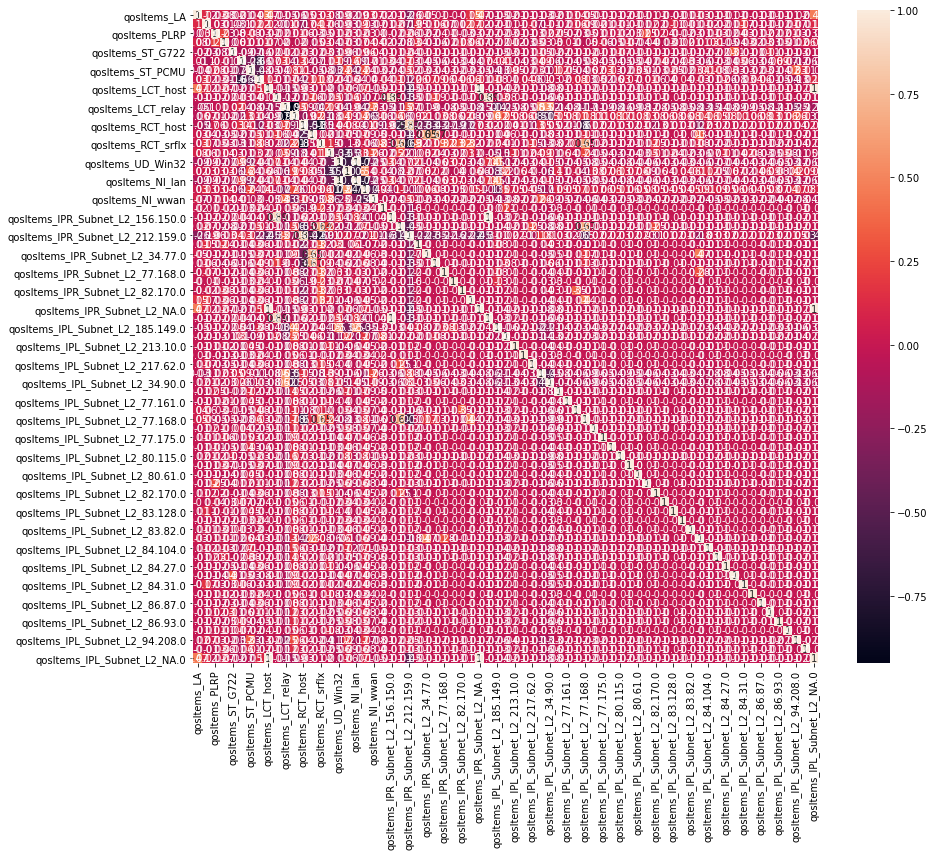

In [26]:
correlation_matrix = sessionRegressionDF.corr().round(2)
plt.figure(figsize=(14, 12))  
sns.heatmap(data=correlation_matrix, annot=True)

c:\users\a474124\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\graphics\regressionplots.py:739: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


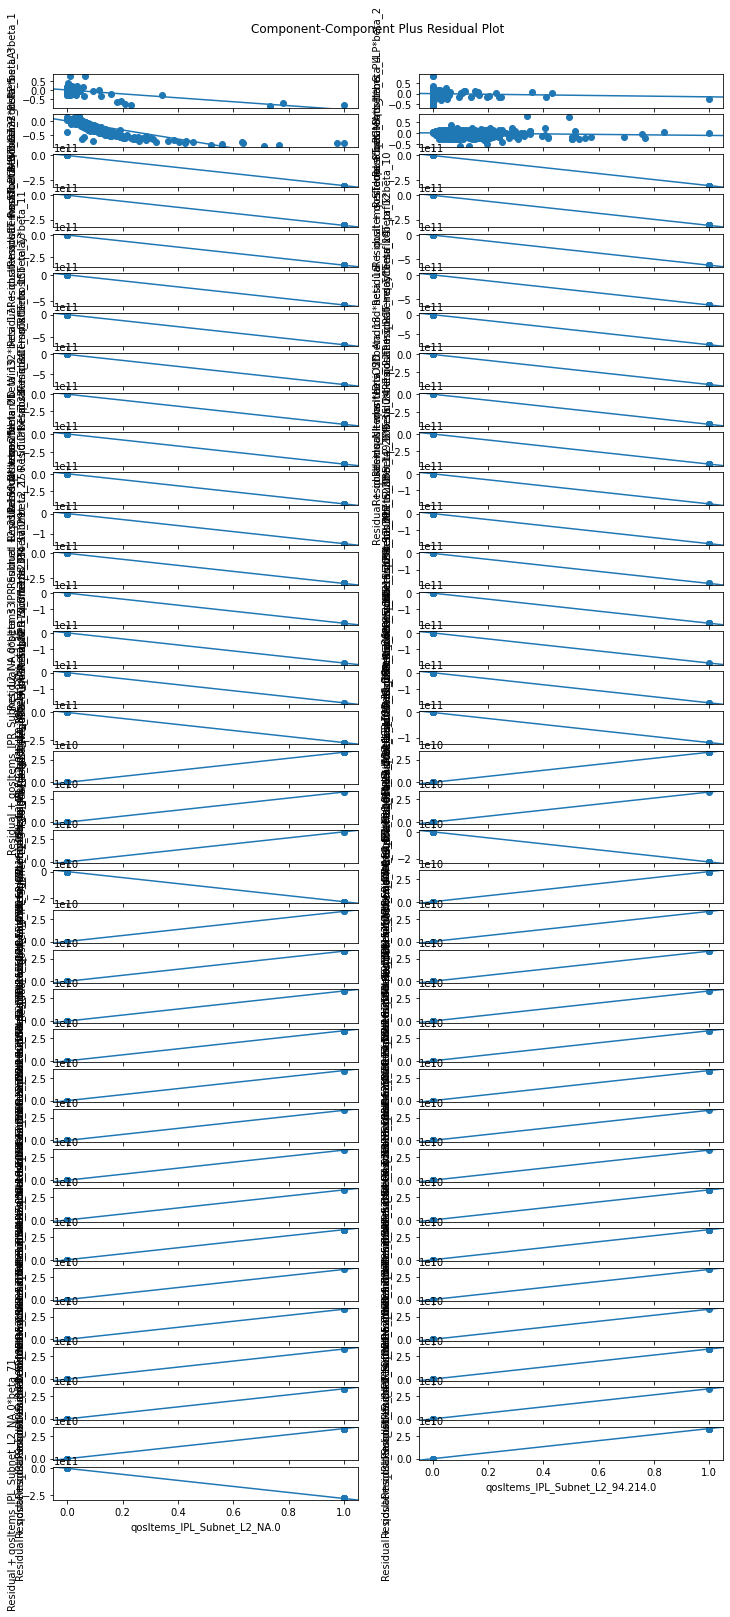

In [27]:
fig = plt.figure(figsize=(12, 24))
fig = sm.graphics.plot_ccpr_grid(regressionResult, fig=fig)